# Model Interpretation for Pretrained ResNet Model

This notebook demonstrates how to apply model interpretability algorithms on pretrained ResNet model using a handpicked images and visualizes the attributions for each pixel by overlaying them on the image.

The interpretation algorithms that we use in this notebook are Integrated Gradients (w/ and w/o noise tunnel) and GradientShap. Noise tunnel allows to smoothen the attributions after adding gaussian noise to each input sample.
  
  **Note:** Before running this tutorial, please install the torchvision, PIL, and matplotlib packages.

In [1]:
import torch
import torch.nn.functional as F

from PIL import Image

import os
import json
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

import torchvision
from torchvision import models
from torchvision import transforms

from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Saliency
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

Loads pretrained Resnet model and sets it to eval mode

In [2]:
model = models.resnet18(pretrained=True)
model = model.eval()

Downloads the list of classes/labels for ImageNet dataset and reads them into the memory

In [ ]:
!wget -P $HOME/.torch/models https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json

In [4]:
labels_path = os.getenv("HOME") + '/.torch/models/imagenet_class_index.json'
with open(labels_path) as json_data:
    idx_to_labels = json.load(json_data)

Defines transformers and normalizing functions for the image.
It also loads an image from the `img/resnet/` folder that will be used for interpretation purposes.

In [5]:
transform = transforms.Compose([
 transforms.Resize(256),
 transforms.CenterCrop(224),
 transforms.ToTensor()
])

transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )

img = Image.open('img/resnet/swan-3299528_1280.jpg')

transformed_img = transform(img)

input = transform_normalize(transformed_img)
input = input.unsqueeze(0)

Predict the class of the input image

In [6]:
output = model(input)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)

pred_label_idx.squeeze_()
predicted_label = idx_to_labels[str(pred_label_idx.item())][1]

This function is used to visualize the image and corresponding attributions by overlaying the latter on the image.

Computes attributions using Integrated Gradients and visualizes them on the image. Integrated gradients computes the integral of the gradients of the output of the model for the predicted class `pred_label_idx` with respect to the input image pixels along the path from the black image to our input image.

Predicted: goose ( 0.4569324851036072 )


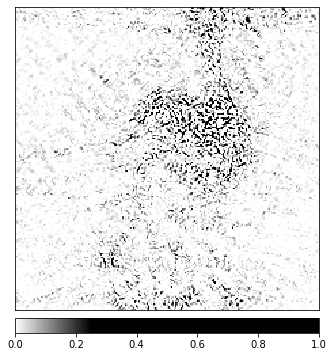

In [7]:
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

integrated_gradients = IntegratedGradients(model)
attributions_ig = integrated_gradients.attribute(input, target=pred_label_idx, n_steps=200)

default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)


_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)

Computes attributions using Integrated Gradients and smoothens them across multiple images generated by noise tunnel. The latter adds gaussian noise with a std equals to one, 10 times (n_samples=10) to the input. Ultimately, noise tunnel smoothens the attributions across `n_samples` noisy samples using `smoothgrad_sq` technique. `smoothgrad_sq` represents the mean of the squared attributions across `n_samples` samples.

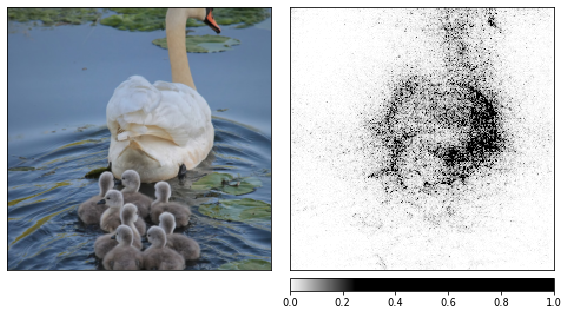

In [8]:
noise_tunnel = NoiseTunnel(integrated_gradients)

attributions_ig_nt = noise_tunnel.attribute(input, n_samples=10, nt_type='smoothgrad_sq', target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)


GradientShap is a linear explanation model which uses a distribution of reference samples (in this case two images) to explain predictions of the model. It computes the expectation of gradients for an input which was chosen randomly between the input and a baseline. The baseline is also chosen randomly from given baseline distribution.

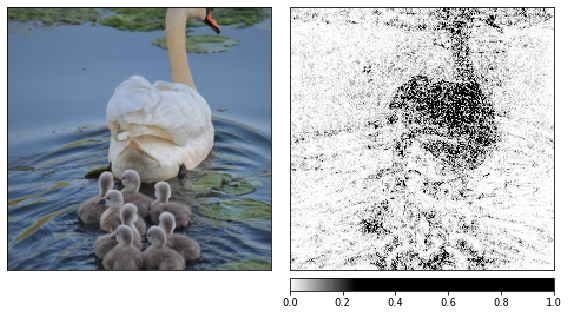

In [9]:
torch.manual_seed(0)
np.random.seed(0)

gradient_shap = GradientShap(model)

# Defining baseline distribution of images
rand_img_dist = torch.cat([input * 0, input * 1])

attributions_gs = gradient_shap.attribute(input,
                                          n_samples=50,
                                          stdevs=0.0001,
                                          baselines=rand_img_dist,
                                          target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "absolute_value"],
                                      cmap=default_cmap,
                                      show_colorbar=True)
